In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
unique_labels = ['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED']
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'], dtype=object)

In [3]:
function_mapping = {'OTHER': ['admiration', 'approval', 'gratitude', 'amusement', 'curiosity', 'embarrassment', 'love', 'optimism', 'joy', 
                              'realization', 'confusion', 'caring', 'excitement', 'surprise', 'desire', 'pride', 'relief', 'neutral'], 
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust', 'annoyance'], 
           'NOT_CORRECT': ['disapproval'], 
           'PESSIMISTIC':['grief', 'remorse', 'sadness'], 
           'WORRIED':['fear', 'nervousness'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': ['disappointment'], 
           'BORED': [''], 
           'NOT_APPROVE':['disapproval'], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': ['disapproval'], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

go_emotions = load_dataset("go_emotions").remove_columns("id")
def adjust_labels(batch):
    batch['emotions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["labels"]):
        batch["emotions"][i] = [mapping[label] for label in batch["labels"][i]]
    return batch

go_emotions = go_emotions.map(adjust_labels, batched=True)
def map_labels(batch):
    batch['functions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["emotions"]):
        batch["functions"][i] = [key for key,value in function_mapping.items() if any(emotion in batch["emotions"][i] for emotion in value)]
    return batch
go_emotions = go_emotions.map(map_labels, batched=True).remove_columns("labels")

# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
go_emotions = go_emotions.map(one_hot_encoding, batched=True)
dataset = go_emotions

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
100%|██████████| 3/3 [00:00<00:00, 729.44it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1c4d70c4ecc5a4bd.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-8f90b5d8ac946ce8.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-f0dc721270e34384.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified

In [4]:
dataset['train'][37]

{'text': 'Famous for his 3-4 Defense',
 'emotions': ['admiration'],
 'functions': ['OTHER'],
 'label_ids': [0, 0, 0, 0, 0, 0, 1, 0, 0]}

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
finetuned_model = 'functions_baseline_single_label/checkpoint-15690'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(finetuned_model,problem_type="multi_label_classification", num_labels = len(labels_classes))).to(device)
tokenizer=AutoTokenizer.from_pretrained(finetuned_model)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)#max_length=512) #for XLM-RoBERTa and emoevent-es, we need to set max_length parameter for this code to work

ds_enc = dataset.map(tokenize, batched=True) #remove_columns=cols)
print(ds_enc)
ds_enc.set_format("torch", columns=["input_ids", "attention_mask", "label_ids"])
ds_enc = (ds_enc
          .map(lambda x : {"float_labels": x["label_ids"].to(torch.float)}, remove_columns=["label_ids"])
          .rename_column("float_labels", "label_ids"))

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-6def43aa32922c3e.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-ff832761cc59288a.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-3de5fbbbd70fde4d.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-585ccde2a2a30353.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cach

DatasetDict({
    train: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 5427
    })
})


In [6]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
    
# source: https://jesusleal.io/2021/04/21/Longformer-multlabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):   
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions)) 
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1   
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [7]:
args = TrainingArguments(".", num_train_epochs=1)

trainer = Trainer(model=model, args=args, 
                  compute_metrics=compute_metrics,                  
                  eval_dataset=ds_enc['test'],
                  tokenizer=tokenizer)

In [8]:
preds_output = trainer.predict(ds_enc['validation'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotions, text, functions. If emotions, text, functions are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5426
  Batch size = 16
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.4908694624900818, 'test_f1': 0.38042313421611884, 'test_roc_auc': 0.7585230768809856, 'test_accuracy': 0.24972355326207152, 'test_runtime': 39.3958, 'test_samples_per_second': 137.73, 'test_steps_per_second': 8.63}


In [9]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

macros, micros, macroprecision, macrorecall = [], [], [], []
y_true = np.array(ds_enc['validation']["label_ids"])
thresholds = np.linspace(0.1, 1, 100)
for threshold in thresholds:
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(preds_output.predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1    
    report = classification_report(y_true, y_pred, target_names=labels_classes, zero_division=0, output_dict=True)
    micros.append(report["micro avg"]["f1-score"])
    macros.append(report["macro avg"]["f1-score"])
    macroprecision.append(report['macro avg']['precision'])
    macrorecall.append(report['macro avg']['recall'])

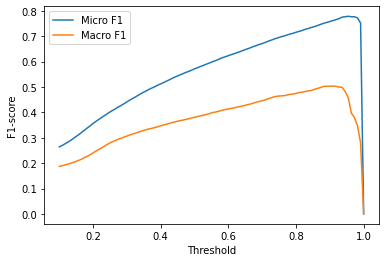

In [10]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

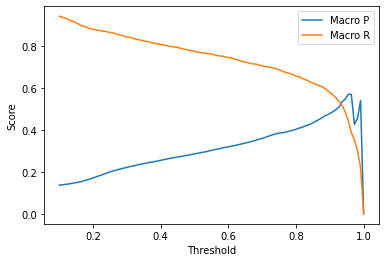

In [11]:
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [12]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.9545454545454545 with F1-score 0.78.
Best threshold (macro): 0.9090909090909091 with F1-score 0.50.
Best threshold (macro-Precision): 0.9545454545454545 with macroP-score 0.57.
Best threshold (macro-Recall): 0.1 with macroR-score 0.94.


## Experiment with eval/test dataset

In [15]:
#output = trainer.evaluate()
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotions, text, functions. If emotions, text, functions are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5427
  Batch size = 16
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.49837425351142883, 'test_f1': 0.37323355355244536, 'test_roc_auc': 0.7588436591857942, 'test_accuracy': 0.24580799705177814, 'test_runtime': 37.8061, 'test_samples_per_second': 143.548, 'test_steps_per_second': 8.993}


In [16]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(preds_output.predictions))
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.9)]= 1
y_true = np.array(ds_enc['test']["label_ids"])

from sklearn.metrics import classification_report

report = classification_report(
  y_true,
  y_pred,
  target_names=labels_classes,
  zero_division=0,
  output_dict=True
)
print(report)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_baseline_goemotions_finetuning_threshold=0.9.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

{'ANGRY': {'precision': 0.39221556886227543, 'recall': 0.6616161616161617, 'f1-score': 0.4924812030075188, 'support': 198}, 'DISAGREE': {'precision': 0.4271356783919598, 'recall': 0.31835205992509363, 'f1-score': 0.3648068669527897, 'support': 267}, 'DISAPPOINTED': {'precision': 0.23595505617977527, 'recall': 0.41721854304635764, 'f1-score': 0.30143540669856456, 'support': 151}, 'DISLIKE': {'precision': 0.3040816326530612, 'recall': 0.6946386946386947, 'f1-score': 0.42299503193754434, 'support': 429}, 'NOT_APPROVE': {'precision': 0.42786069651741293, 'recall': 0.32209737827715357, 'f1-score': 0.36752136752136755, 'support': 267}, 'NOT_CORRECT': {'precision': 0.425531914893617, 'recall': 0.299625468164794, 'f1-score': 0.3516483516483516, 'support': 267}, 'OTHER': {'precision': 0.8867844222174931, 'recall': 0.9500683994528044, 'f1-score': 0.9173362685745735, 'support': 4386}, 'PESSIMISTIC': {'precision': 0.5, 'recall': 0.8207547169811321, 'f1-score': 0.6214285714285714, 'support': 212}, 

In [17]:
import torch.nn as nn
def loss_fn(outputs, labels):
    if labels is None:
        return None
    loss_values = []
    for f, b in zip(outputs, labels):
        loss_value = nn.BCEWithLogitsLoss()(f, b.float())
        loss_values.append(loss_value)
    torch_loss = torch.tensor(loss_values)
    return torch_loss

def forward_pass_with_label(batch): 
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}      
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits        
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())       
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.9)] = 1       
        loss = loss_fn(logits, batch["label_ids"].to(device))
    return {"loss": loss.cpu().numpy(), 
            "pred_label_ids": predictions}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label_ids"])
ds_enc = ds_enc.map(
    forward_pass_with_label, batched=True, batch_size = 8)

In [18]:
def get_predicted_labels(batch):
    transformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))  
    return  {"predicted_labels": list(map(list, transformed_into_label_names))}
ds_enc['test'] = ds_enc['test'].map(get_predicted_labels, batched=True)

ds_enc.set_format("pandas")
cols = ["text", "emotions", "functions", "predicted_labels", "loss"]
df_test = ds_enc['test'][:][cols]
loss_values = df_test.sort_values("loss", ascending=False).head(50)
print(loss_values)

                                                   text  \
3655                                Hasn’t hurt me none   
509   People like you with premature ejaculation and...   
4066  WERE* protesting This is not current. Misleading.   
2276  Ahhhhh you should start screaming and flailing...   
4980  It's the universe trying to kill us with radia...   
2430  Her lying, narcotics addicted, pedophilic gran...   
137   The worst bbq in Texas Edit: Some of you are g...   
5318  Can't you tell that [NAME] is a serious threat...   
1734          Same...except that I'm not good looking :   
4959  Definitely the current worst, hence 20 actuall...   
4031  >the silent majority This is the most ignorant...   
1924                 I'd rather die than drive a Volvo!   
2476  Yeah, it's pretty funny how incapable most of ...   
4347  Oooo I see, I was hoping it wasn't a troll thi...   
1064  I can see why you’ll never be in a leadership ...   
1970        Plot twist: they don‘t Want to Go To school 

In [19]:
loss_values.to_csv('loss_values_baseline_finetuning_threshold=0.9.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_baseline_finetuning_threshold=0.9.tsv',header =True, sep = '\t',index=False)